# Exploring Gradient Descent with 1D ReLUs

## Summary

- This notebook explores something that seems simple at first: fitting a ReLU ($a_1 \text{relu}(b_1 x)$) to a ReLU ($a_2 \text{relu}(b_2 x)$) using gradient descent.
- However, with a fixed $a_1 = a_2 = 1$, a simple implementation of gradient descent with a mean square error cannot fit $\text{relu}(b_1 x)$ to $\text{relu}(b_2 x)$, where $b_2$ is negative and the initial value of $b_1$ is positive. This is because the gradient of the (mean square) loss vanishes with $b_1 = 0$.
- While this simple case can be resolved by having a linear error (mean absolute value), the problem also arises when adding a degree of freedom to the optimization, by fitting $a_1 \text{relu}(b_1 x)$ to $\text{relu}(b_2 x)$ (with negative $b_2$), not resolvable by mean absolute value error. This 2-parameter case also has some issues fitting $-\text{relu}(b_2 x)$, depending on the initial parameters for the gradient descent.
- One approach to resolving this isssue (in both cases) is to add a source of noise to the gradient descent, allowing it to 'jump over the cliff' at $b_1 = 0$.
- In many deep learning cases, a source of noise is automatically present, as the data is sampled and stochastic gradient descent is applied.
- A second approach is to provide more ReLUs to the gradient descent, allowing the ones with the 'wrong' signs to be pushed to zero, while the 'correct' signs will fit the function.

## Preliminaries

First, some imports and preliminaries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
torch.manual_seed(12345678)
print(f"{torch.__version__=}")

torch.__version__='2.1.2'


## The ReLU

A ReLU is given by

\begin{equation}
    f(x) = \max(0, x) = \frac{x + |x|}{2} = 
    \begin{cases} 
        x & \text{if } x > 0, \\ 
        0 & \text{otherwise}
    \end{cases}
\end{equation}

A ReLU is a popular choice for the activation function in a (possibly deep) neural network.

Plotting $y = a . \text{relu}(b x)$:

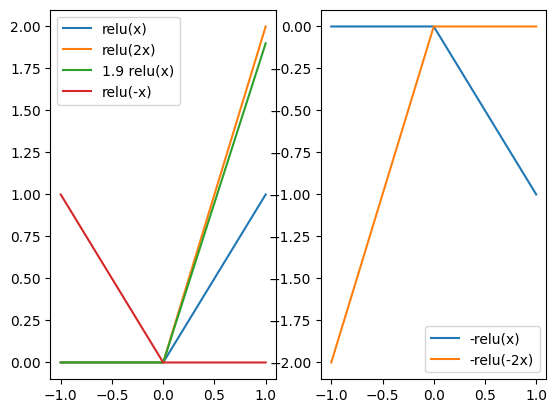

In [2]:
xs = torch.linspace(-1, 1, 101)
relu1 = torch.relu(xs)
relu2 = torch.relu(2 * xs)
relu3 = 1.9 * torch.relu(xs)
relu4 = torch.relu(-xs)
relu5 = -torch.relu(xs)
relu6 = -torch.relu(-2 * xs)

fig, axs = plt.subplots(1, 2)
axs[0].plot(xs, relu1, label="relu(x)")
axs[0].plot(xs, relu2, label="relu(2x)")
axs[0].plot(xs, relu3, label="1.9 relu(x)")
axs[0].plot(xs, relu4, label="relu(-x)")
axs[0].legend()

axs[1].plot(xs, relu5, label="-relu(x)")
axs[1].plot(xs, relu6, label="-relu(-2x)")
axs[1].legend()

plt.show()

Hence, changing the value of a is mostly degenerate with changing b - except for a change of sign.

For a positive $a$, $\text{relu}(ax) = a . \text{relu}(x)$.

However, $\text{relu}(-x)$ cannot be produced by any value of a in $a . \text{relu}(x)$.

## Optimizing

In [3]:
def optimize(initial_params, inputs, predict, loss, step_size, n = 10000):
    params = torch.clone(initial_params).detach().requires_grad_(True)
    initial_predictions = predict(params, inputs)
    initial_loss = loss(initial_predictions)
    
    for i in range(n):
        predictions = predict(params, inputs)
        this_loss = loss(predictions)
    
        if (i + 1) % int(n / 10) == 0:
            print(f"Step {i + 1}, loss = {this_loss.item()}")
    
        params.grad = None
        this_loss.backward()
        params.data += -step_size * params.grad
    
    return params


def display_results(initial_predictions, final_predictions, targets):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(inputs, initial_predictions.detach(), label="Predictions")
    axs[0].plot(inputs, targets, label="Targets")
    axs[0].set_title("Initial")
    axs[0].legend()
    axs[1].plot(inputs, final_predictions.detach(), label="Predictions")
    axs[1].plot(inputs, targets, label="Targets")
    axs[1].set_title("Final")
    axs[1].legend()
    plt.show()


def display_loss(inputs, predict, loss):
    all_params = torch.reshape(torch.linspace(-1, 1, 51), (-1, 1, 1))
    results = torch.vmap(predict)(all_params, inputs.expand(51, -1, -1))
    losses = torch.vmap(loss)(results)
    fig, axs = plt.subplots()
    axs.plot(all_params.reshape((-1, )), losses)
    axs.set_title("Loss")
    plt.show()

### Fitting relu(a x) for positive and negative a

In the obvious case, the gradient descent algorithm can fit $\text{relu}(a x)$.

Step 1000, loss = 0.00039402086986228824
Step 2000, loss = 0.00039402086986228824
Step 3000, loss = 0.00039402086986228824
Step 4000, loss = 0.00039402086986228824
Step 5000, loss = 0.00039402086986228824
Step 6000, loss = 0.00039402086986228824
Step 7000, loss = 0.00039402086986228824
Step 8000, loss = 0.00039402086986228824
Step 9000, loss = 0.00039402086986228824
Step 10000, loss = 0.00039402086986228824
Final params = 0.5011059045791626


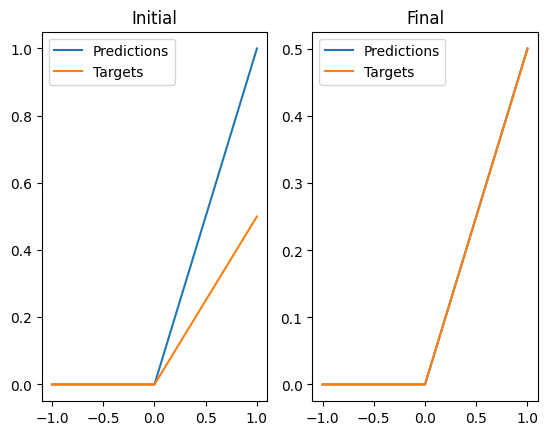

In [4]:
def predict(params, inputs):
    return torch.relu(inputs @ params)

params = torch.tensor([[1.]])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([[0.5]]), inputs)

def loss(predictions):
    return torch.sqrt(torch.pow(predictions - targets, 2).mean())

fitted_params = optimize(params, inputs, predict, loss, 0.005)

print(f"Final params = {fitted_params.item()}")
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

However, when starting with a relu(a x) with a positive, cannot get past the vanishing gradient when using (root) mean square errors.

Step 1000, loss = 0.20664173364639282
Step 2000, loss = 0.20615540444850922
Step 3000, loss = 0.20615528523921967
Step 4000, loss = 0.20615528523921967
Step 5000, loss = 0.20615528523921967
Step 6000, loss = 0.20615528523921967
Step 7000, loss = 0.20615528523921967
Step 8000, loss = 0.20615528523921967
Step 9000, loss = 0.20615528523921967
Step 10000, loss = 0.20615528523921967
Final params = 2.431048871912468e-18


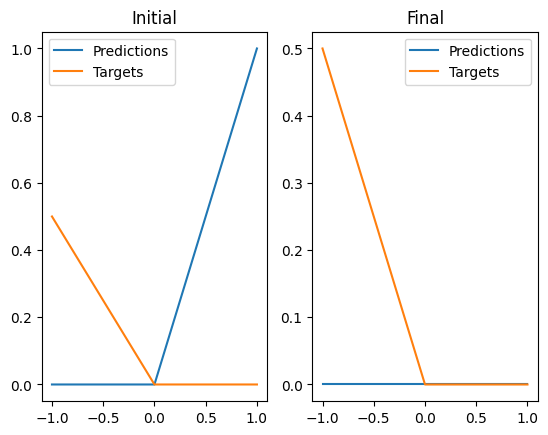

In [5]:
def predict(params, inputs):
    return torch.relu(inputs @ params)

params = torch.tensor([[1.]])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([[-0.5]]), inputs)

def loss(predictions):
    return torch.sqrt(torch.pow(predictions - targets, 2).mean())

fitted_params = optimize(params, inputs, predict, loss, 0.005)

print(f"Final params = {fitted_params.item()}")
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

The ReLU gets stuck at a ~zero coefficient. This is because the gradient of the loss disappears there.

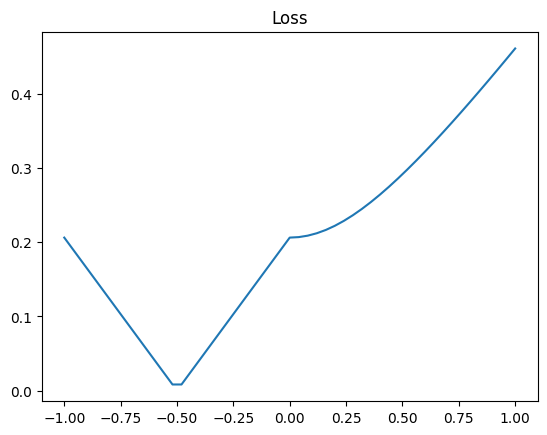

In [6]:
display_loss(inputs, predict, loss)

In this case, this can be solved by using a linear / absolute value error, the gradient persists through:

Step 1000, loss = 0.060314033180475235
Step 2000, loss = 0.00024207313254009932
Step 3000, loss = 0.00024207313254009932
Step 4000, loss = 0.00024207313254009932
Step 5000, loss = 0.00024207313254009932
Step 6000, loss = 0.00024207313254009932
Step 7000, loss = 0.00024207313254009932
Step 8000, loss = 0.00024207313254009932
Step 9000, loss = 0.00024207313254009932
Step 10000, loss = 0.00024207313254009932
Final params = -0.49969643354415894


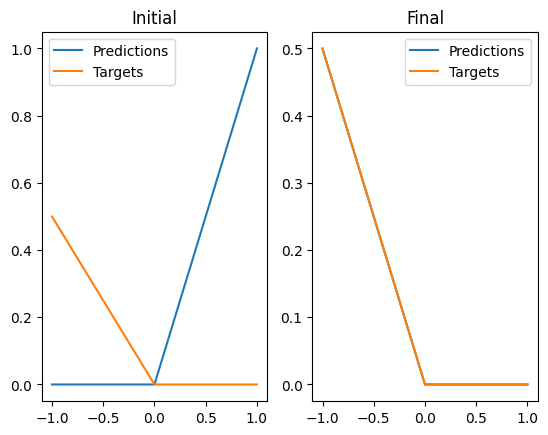

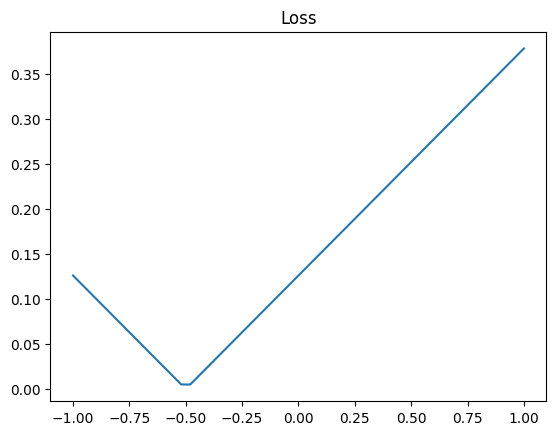

In [7]:
def loss(predictions):
    return torch.abs(predictions - targets).mean()

fitted_params = optimize(params, inputs, predict, loss, 0.005)

print(f"Final params = {fitted_params.item()}")
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)
display_loss(inputs, predict, loss)

### Fitting a relu(x) for positive and negative a

In a similar problem, it is possible to get through from relu(x) to - relu(x) when using a mean square error, as the loss does not show a vanishing gradient as above:

Step 1000, loss = 0.012771771289408207
Step 2000, loss = 0.00042500472045503557
Step 3000, loss = 1.4143770385999233e-05
Step 4000, loss = 4.707195273567777e-07
Step 5000, loss = 1.5665976960121952e-08
Step 6000, loss = 5.285584747660721e-10
Step 7000, loss = 1.441672822788398e-11
Step 8000, loss = 1.3048707080132171e-11
Step 9000, loss = 1.3048707080132171e-11
Step 10000, loss = 1.3048707080132171e-11
Final params = -0.499991238117218


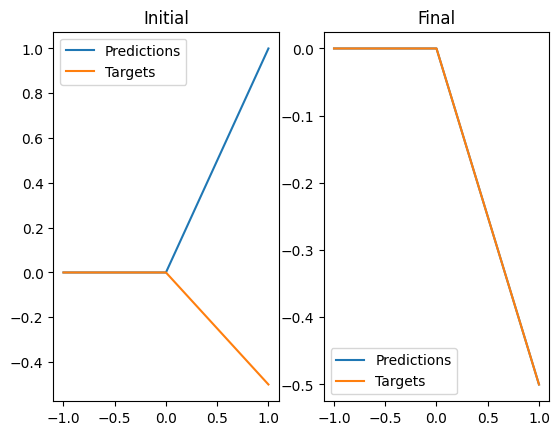

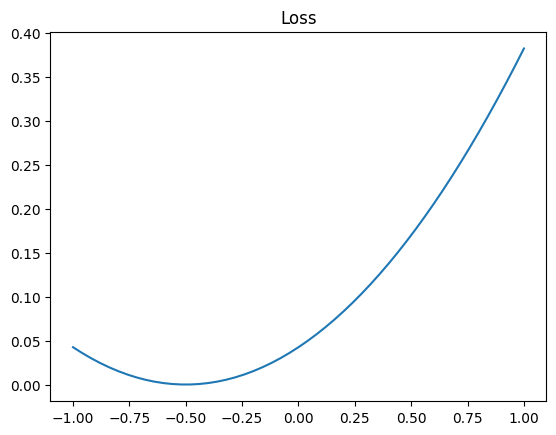

In [8]:
def predict(params, inputs):
    return params * torch.relu(inputs)

params = torch.tensor([[1.]])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([[-0.5]]), inputs)

def loss(predictions):
    return torch.pow(predictions - targets, 2).mean()

fitted_params = optimize(params, inputs, predict, loss, 0.005)

print(f"Final params = {fitted_params.item()}")
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)
display_loss(inputs, predict, loss)

### Fitting $a_1 \text{relu}(b_1x)$

We can give the optimizer an extra degree of freedom by allowing it to fit $a . \text{relu}(b x)$ - knowing that $a$ and $b$ are mostly degenerate, up to a change in sign.

However, it still can't make it's way to a negative b (because it gets pinned into a place with a = 0):

Step 1000, loss = 0.010625004768371582
Step 2000, loss = 0.010625000111758709
Step 3000, loss = 0.010625000111758709
Step 4000, loss = 0.010625000111758709
Step 5000, loss = 0.010625000111758709
Step 6000, loss = 0.010625000111758709
Step 7000, loss = 0.010625000111758709
Step 8000, loss = 0.010625000111758709
Step 9000, loss = 0.010625000111758709
Step 10000, loss = 0.010625000111758709
tensor([1.0592e-31, 4.5433e-01], requires_grad=True)


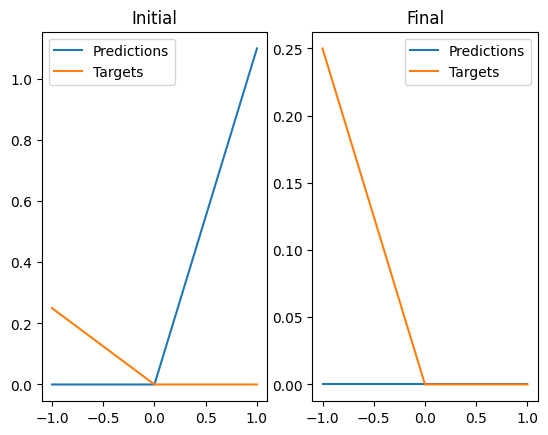

In [9]:
def predict(params, inputs):
    return params[0] * torch.relu(inputs * params[1])

params = torch.tensor([1., 1.1])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([0.5, -0.5]), inputs)

def loss(predictions):
    return torch.pow(predictions - targets, 2).mean()

fitted_params = optimize(params, inputs, predict, loss, 0.1)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

And in fact, in certain situations it finds it difficult getting past a = 0, either when the initial a=b:

Step 1000, loss = 0.010625000111758709
Step 2000, loss = 0.010625000111758709
Step 3000, loss = 0.010625000111758709
Step 4000, loss = 0.010625000111758709
Step 5000, loss = 0.010625000111758709
Step 6000, loss = 0.010625000111758709
Step 7000, loss = 0.010625000111758709
Step 8000, loss = 0.010625000111758709
Step 9000, loss = 0.010625000111758709
Step 10000, loss = 0.010625000111758709
tensor([ 1.1237e-09, -2.8949e-12], requires_grad=True)


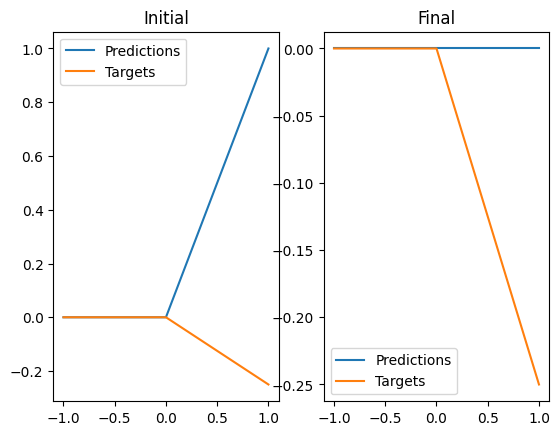

In [10]:
def predict(params, inputs):
    return params[0] * torch.relu(inputs * params[1])

params = torch.tensor([1., 1.])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([-0.5, 0.5]), inputs)

def loss(predictions):
    return torch.pow(predictions - targets, 2).mean()

fitted_params = optimize(params, inputs, predict, loss, 0.1)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

or when the initial a > initial b

Step 1000, loss = 0.010625000111758709
Step 2000, loss = 0.010625000111758709
Step 3000, loss = 0.010625000111758709
Step 4000, loss = 0.010625000111758709
Step 5000, loss = 0.010625000111758709
Step 6000, loss = 0.010625000111758709
Step 7000, loss = 0.010625000111758709
Step 8000, loss = 0.010625000111758709
Step 9000, loss = 0.010625000111758709
Step 10000, loss = 0.010625000111758709
tensor([ 4.5137e-01, -1.0059e-33], requires_grad=True)


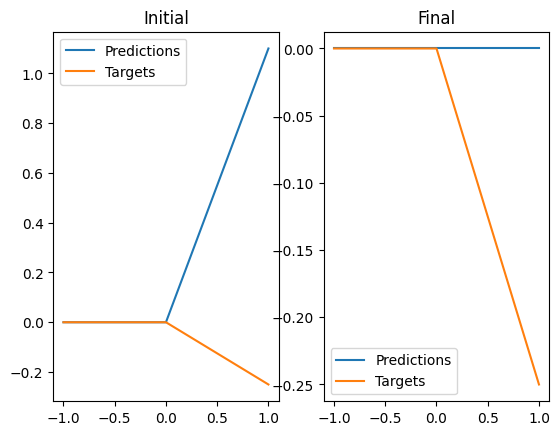

In [11]:
params = torch.tensor([1.1, 1.])
initial_predictions = predict(params, inputs)
fitted_params = optimize(params, inputs, predict, loss, 0.1)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

But it's ok when the initial a < initial b:

Step 1000, loss = 8.629847460554438e-14
Step 2000, loss = 8.629847460554438e-14
Step 3000, loss = 8.629847460554438e-14
Step 4000, loss = 8.629847460554438e-14
Step 5000, loss = 8.629847460554438e-14
Step 6000, loss = 8.629847460554438e-14
Step 7000, loss = 8.629847460554438e-14
Step 8000, loss = 8.629847460554438e-14
Step 9000, loss = 8.629847460554438e-14
Step 10000, loss = 8.629847460554438e-14
tensor([-0.4103,  0.6093], requires_grad=True)


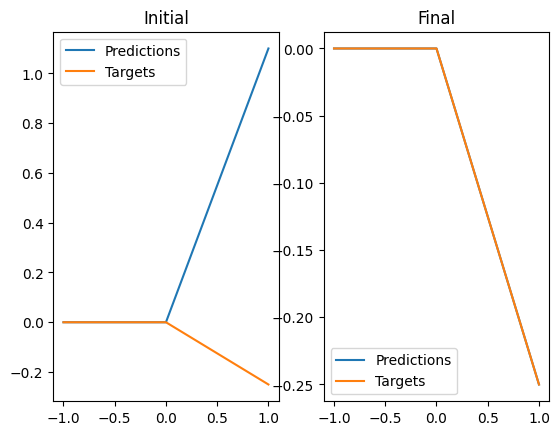

In [12]:
params = torch.tensor([1., 1.1])
initial_predictions = predict(params, inputs)
fitted_params = optimize(params, inputs, predict, loss, 0.1)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

This can be explained in the form of the loss. 

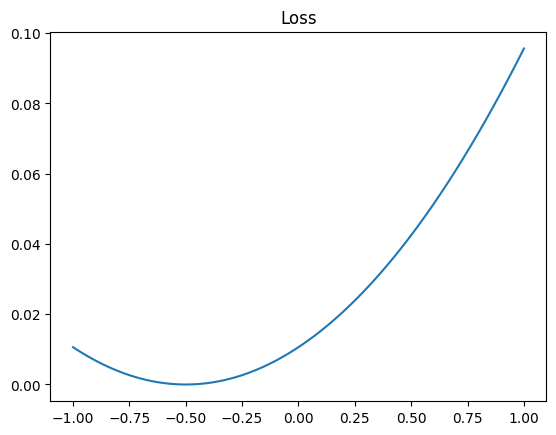

In [13]:
a = torch.linspace(-1, 1, 91).reshape(-1, 1)
b = torch.as_tensor([0.5] * 91).reshape(-1, 1)
xys = torch.stack((a, b), dim=1)
predictions = torch.vmap(predict)(xys, inputs.expand(xys.shape[0], -1, -1))
losses = torch.vmap(loss)(predictions)

fig, axs = plt.subplots()
axs.plot(a, losses)
axs.set_title("Loss")
plt.show()

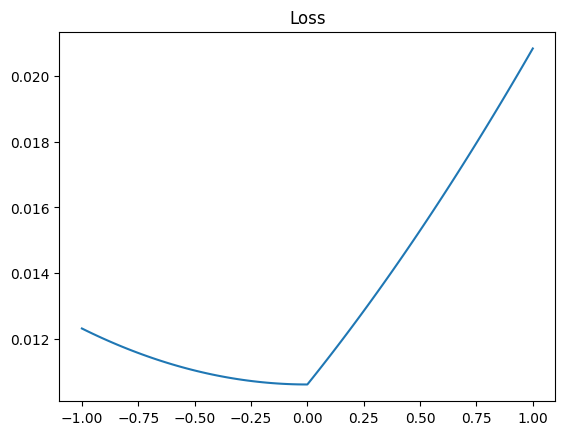

In [14]:
a = torch.as_tensor([0.1] * 91).reshape(-1, 1)
b = torch.linspace(-1, 1, 91).reshape(-1, 1)
xys = torch.stack((a, b), dim=1)
predictions = torch.vmap(predict)(xys, inputs.expand(xys.shape[0], -1, -1))
losses = torch.vmap(loss)(predictions)

fig, axs = plt.subplots()
axs.plot(b, losses)
axs.set_title("Loss")
plt.show()

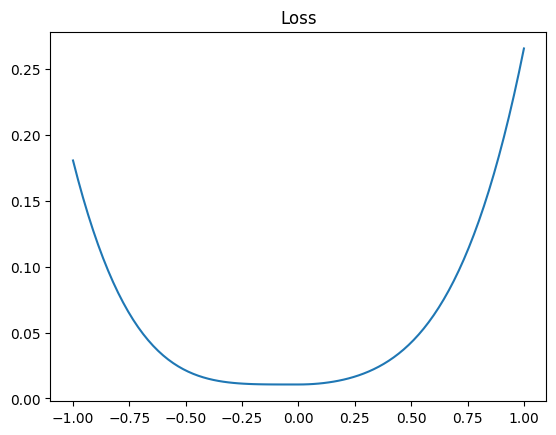

In [15]:
a = torch.linspace(-1, 1, 91).reshape(-1, 1)
b = a
xys = torch.stack((a, b), dim=1)
predictions = torch.vmap(predict)(xys, inputs.expand(xys.shape[0], -1, -1))
losses = torch.vmap(loss)(predictions)

fig, axs = plt.subplots()
axs.plot(b, losses)
axs.set_title("Loss")
plt.show()

In [16]:
params = torch.tensor([0.8, 1.2], requires_grad=True)
predictions = predict(params, inputs)
this_loss = loss(predictions)
params.grad = None
this_loss.backward()
params.grad

tensor([0.4937, 0.3291])

### Fixing it

How to get around this? Could try and write rules such that small gradients automatically get moved. However, a brute force way could be to just add some noise:

In [17]:
def optimize2(initial_params, inputs, predict, loss, step_size, n = 10000):
    params = torch.clone(initial_params).detach().requires_grad_(True)
    initial_predictions = predict(params, inputs)
    initial_loss = loss(initial_predictions)
    
    for i in range(n):
        predictions = predict(params, inputs)
        this_loss = loss(predictions)
    
        params.grad = None
        this_loss.backward()
        params.data += -step_size * params.grad

        if i % 100 == 0:   
            noise = torch.normal(mean=0, std=0.1, size=params.shape, requires_grad=False)
            params.data += noise

        if (i + 1) % int(n / 10) == 0:
            print(f"Step {i + 1}, loss = {this_loss.item()}")
    
    return params

Step 1000, loss = 0.20627917349338531
Step 2000, loss = 0.20651055872440338
Step 3000, loss = 0.001374393585138023
Step 4000, loss = 0.0014080716064199805
Step 5000, loss = 0.0034581332001835108
Step 6000, loss = 0.00252329558134079
Step 7000, loss = 0.005511732306331396
Step 8000, loss = 0.0013795946724712849
Step 9000, loss = 0.0047692907974123955
Step 10000, loss = 0.0056746904738247395
tensor([-0.8002, -0.6150], requires_grad=True)


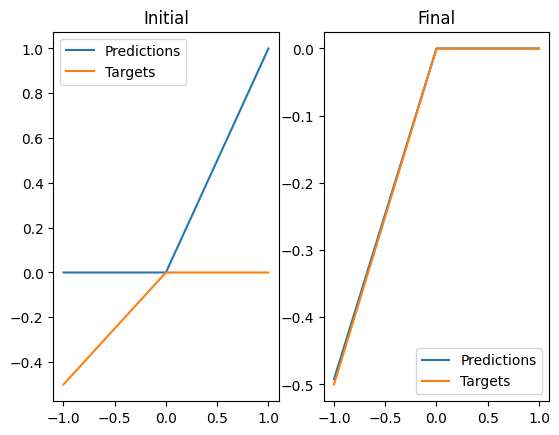

In [18]:
def predict(params, inputs):
    return params[0] * torch.relu(inputs * params[1])

params = torch.tensor([1., 1.])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = predict(torch.tensor([-0.5, -1.0]), inputs)

def loss(predictions):
    return torch.sqrt(torch.pow(predictions - targets, 2).mean())

fitted_params = optimize2(params, inputs, predict, loss, 0.05, n = 10000)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)

In a deep learning context, noise is automatically part of the process of Stochastic Gradient Descent, making it less likely to get stuck.

Another approach is to fit 2 ReLUs, one with +ve and one with -ve. The 'wrong' one will be pushed to zero, and the 'correct' one will provide the fit.

Step 1000, loss = 0.003803420579060912
Step 2000, loss = 0.003803420579060912
Step 3000, loss = 0.003803420579060912
Step 4000, loss = 0.003803420579060912
Step 5000, loss = 0.003803420579060912
Step 6000, loss = 0.003803420579060912
Step 7000, loss = 0.003803420579060912
Step 8000, loss = 0.003803420579060912
Step 9000, loss = 0.003803420579060912
Step 10000, loss = 0.003803420579060912
tensor([-0.0063, -0.5095], requires_grad=True)


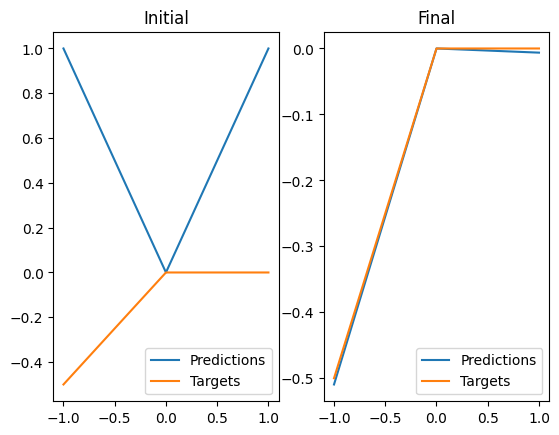

In [19]:
def predict(params, inputs):
    return params[0] * torch.relu(inputs) + params[1] * torch.relu(-inputs)

params = torch.tensor([1., 1.])
inputs = torch.reshape(torch.linspace(-1, 1, 101), (-1, 1))
initial_predictions = predict(params, inputs)
targets = -0.5 * torch.relu(-1.0 * inputs)

def loss(predictions):
    return torch.sqrt(torch.pow(predictions - targets, 2).mean())

fitted_params = optimize(params, inputs, predict, loss, 0.05, n = 10000)

print(fitted_params)
final_predictions = predict(fitted_params, inputs)
display_results(initial_predictions, final_predictions, targets)